# SST processing for ML 
### need monthly gridded values 1982-2020

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import scipy
import sklearn.linear_model 
import pickle

import xesmf

In [2]:
# SOCAT Grid
###################################
socat = xr.open_dataset('/data/artemis/observations/SOCAT/originals/SOCATv2020_tracks_gridded_monthly.nc')
fco2_weighted = socat.fco2_ave_weighted
time = fco2_weighted.tmnth
ylat = fco2_weighted.ylat
xlon = fco2_weighted.xlon


In [9]:
# SST Data and Grid 
####################################
noaa = xr.open_dataset('/data/artemis/workspace/vbennington/NOAA_SST/originals/sst.mnmean.nc')
sst = noaa.sst
ntime = sst.time
nlat = sst.lat
nlon = sst.lon

In [10]:
# SST from NOAA (ntime) is 1981-12 to 2020-12

sst = sst[1:469,:,:]
ntime = ntime[1:469]

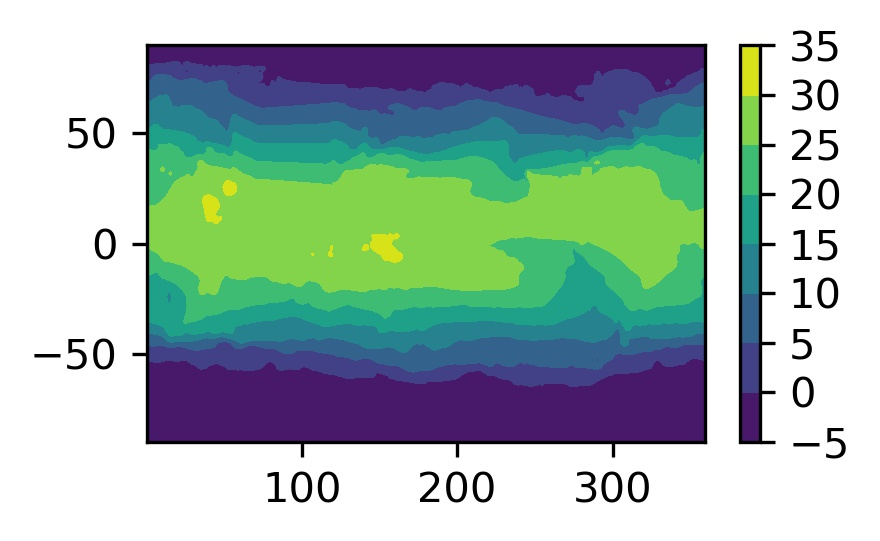

In [31]:
fig = plt.subplots(1,1,figsize=(3,1.75))
plt.contourf(nlon,nlat,sst[225,:,:])
plt.colorbar()

In [17]:
date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2020-12-31T00:00:00.000000000'

# create date vector
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

In [21]:
ngrid = xr.Dataset({'lat':(['lat'],nlat.values),'lon':(['lon'],nlon.values)})
sgrid = xr.Dataset({'lat':(['lat'],ylat.values),'lon':(['lon'],xlon.values)})
sst_in = xr.Dataset({'sst':(['time','lat','lon'],sst),'time':(['time'],dates.values),'lat':(['lat'],nlat.values),'lon':(['lon'],nlon.values)})

In [22]:
# Now let's grab 1982 - 2020 and write to file:
regridder = xesmf.Regridder(sst_in, sgrid, 'bilinear')

Overwrite existing file: bilinear_180x360_180x360.nc 
 You can set reuse_weights=True to save computing time.


In [20]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_180x360_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (180, 360) 
Output grid shape:          (180, 360) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [24]:
sst_out = regridder(sst_in.sst)

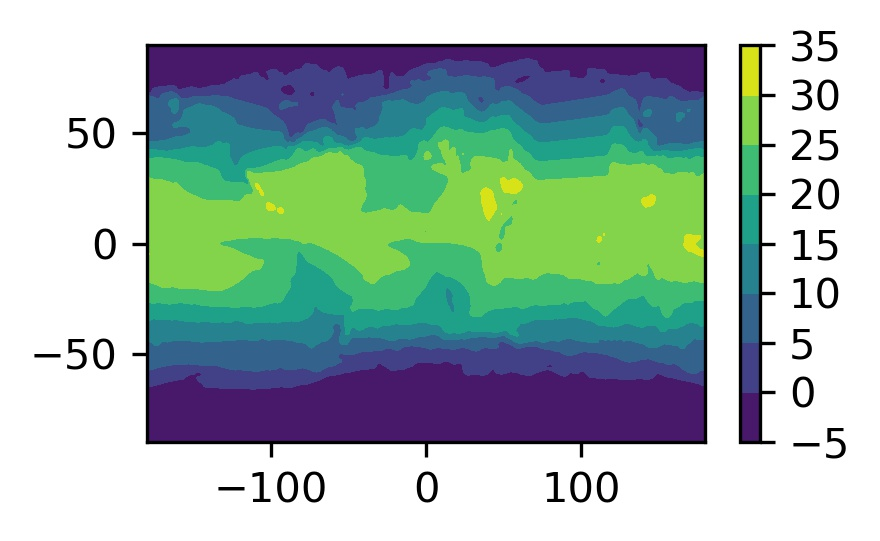

In [30]:
fig = plt.figure(figsize=(3,1.75))
plt.contourf(xlon,ylat,sst_out[150,:,:])
plt.colorbar()

In [29]:
sst_final_out = xr.Dataset({
                        'sst':(["time","ylat","xlon"],sst_out)},
                        coords={'time': (['time'],dates),
                        'ylat': (['ylat'],ylat),
                        'xlon':(['xlon'],xlon)})
        
    # Save to netcdf
sst_final_out.to_netcdf('/data/artemis/workspace/vbennington/NOAA_SST/processed/SST_mon_198201-202012.nc') 